In [736]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [737]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [738]:
NUM_CLASSES = 5

# Dataset reading

In [739]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (478 * 2) + 1)))

In [740]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [741]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Model building

In [742]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((478 * 2, )),
#     tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'),
#     tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal'),
#     tf.keras.layers.Dense(16, activation='selu', kernel_initializer='lecun_normal'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((478 * 2, )),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [743]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 20)                19140     
                                                                 
 dropout_86 (Dropout)        (None, 20)                0         
                                                                 
 dense_136 (Dense)           (None, 10)                210       
                                                                 
 dense_137 (Dense)           (None, 5)                 55        
                                                                 
Total params: 19,405
Trainable params: 19,405
Non-trainable params: 0
_________________________________________________________________


In [744]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [745]:
# Model compilation
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [746]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
42/75 [===============>..............] - ETA: 0s - loss: 1.5240 - accuracy: 0.3328 
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
75/75 [==============================] - 0s 3ms/step - loss: 1.4114 - accuracy: 0.4166 - val_loss: 1.0966 - val_accuracy: 0.6219
Epoch 2/1000
50/75 [===================>..........] - ETA: 0s - loss: 1.0692 - accuracy: 0.6288
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
75/75 [==============================] - 0s 2ms/step - loss: 1.0157 - accuracy: 0.6526 - val_loss: 0.7701 - val_accuracy: 0.7747
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 0.7589 - accuracy: 0.7383
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
75/75 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 0.7391 - val_loss: 0.5567 - val_accuracy: 0.8338
Epoch 4/1000
44/75 [================>.............] - ETA: 0s - loss: 0.6174 - accur

In [747]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 [==============================] - 0s 777us/step - loss: 0.0659 - accuracy: 0.9774


In [748]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [749]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.8647752e-10 1.0000000e+00 4.4540444e-15 1.1016403e-18 8.2022105e-09]
1


# Confusion matrix

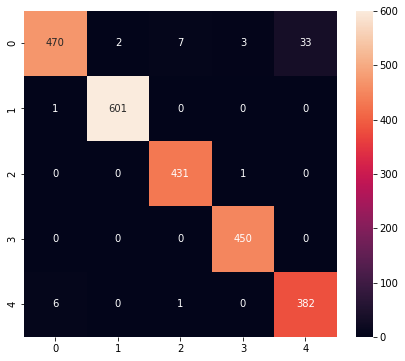

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       515
           1       1.00      1.00      1.00       602
           2       0.98      1.00      0.99       432
           3       0.99      1.00      1.00       450
           4       0.92      0.98      0.95       389

    accuracy                           0.98      2388
   macro avg       0.98      0.98      0.98      2388
weighted avg       0.98      0.98      0.98      2388



In [750]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [751]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [752]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ratta\AppData\Local\Temp\tmpe31ea_65\assets


INFO:tensorflow:Assets written to: C:\Users\Ratta\AppData\Local\Temp\tmpe31ea_65\assets


22432

# Inference test

In [753]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [754]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [755]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [756]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [757]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.2188655e-10 1.0000000e+00 3.5894669e-15 7.3437989e-19 7.6229787e-09]
1
